# Baseline Comparisons and Linear Regression for Trend IMF

In [1]:
import gsod
import numpy as np
from matplotlib import pyplot as plt

gsod.enable_svg_graphing()

In [2]:
STATION = "722860"
ds = gsod.GsodDataset("runtime/GSOD")
interpolated = ds.read_continuous(stn=STATION, year="????", interpolate=True)
interpolated.head()

,STN,WBAN,TEMP,TEMP_COUNT,DEWP,DEWP_COUNT,SLP,SLP_COUNT,STP,STP_COUNT,...,MIN_FLAG,PRCP,PRCP_FLAG,SNDP,FOG,RAIN,SNOW,HAIL,THUNDER,TORNADO
1933-01-01,722860.0,23119.0,56.6,9.0,9999.9,0.0,9999.9,0.0,9999.9,0.0,...,*,0.0,I,999.9,False,False,False,False,False,False
1933-01-02,722860.0,23119.0,57.0,9.0,9999.9,0.0,1018.5,9.0,9999.9,0.0,...,*,0.0,I,999.9,False,False,False,False,False,False
1933-01-03,722860.0,23119.0,51.5,9.0,9999.9,0.0,1018.8,9.0,9999.9,0.0,...,*,0.0,I,999.9,False,False,False,False,False,False
1933-01-04,722860.0,23119.0,58.9,9.0,9999.9,0.0,1021.4,9.0,9999.9,0.0,...,*,0.0,I,999.9,False,False,False,False,False,False
1933-01-05,722860.0,23119.0,64.6,9.0,9999.9,0.0,1019.8,9.0,9999.9,0.0,...,*,0.0,I,999.9,False,False,False,False,False,False


## Reusing Yesterday's Termperature as Prediction

Text(0, -50, 'MAE: 2.739${}^\\circ$F\nRMSE: 3.546${}^\\circ$F')

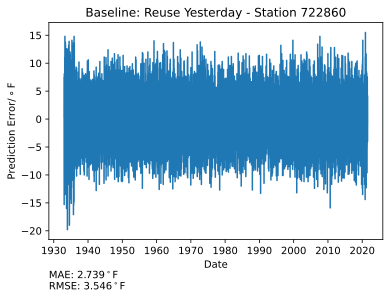

In [3]:
Y = np.asarray(interpolated["TEMP"])
error = Y[1:] - Y[:-1]
plt.plot(interpolated.index[1:], error)
plt.xlabel("Date")
plt.ylabel("Prediction Error/${}\circ$F")
plt.title(f"Baseline: Reuse Yesterday - Station {STATION}")
plt.annotate(
    f"MAE: {np.average(np.abs(error)):0.4}${{}}^\circ$F\n"
    + f"RMSE: {np.average(error ** 2) ** 0.5:0.4}${{}}^\circ$F",
    (0, -50),
    xycoords="axes points"
)

In [4]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

X = gsod.sliding_window(np.asarray(interpolated["TEMP"]), 7)[:-1]
Y = np.asarray(interpolated["TEMP"])[7:]

lr.fit(X[:20000], Y[:20000])

LinearRegression()

Text(0, -50, 'MAE: 2.602${}^\\circ$F\nRMSE: 3.365${}^\\circ$F')

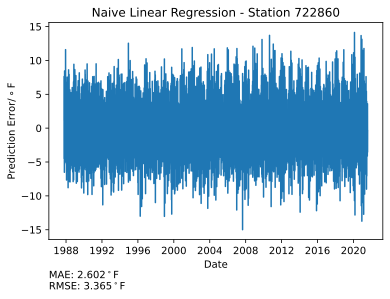

In [5]:
Ypredict = lr.predict(X[20000:])

plt.plot(interpolated.index[20007:], Ypredict - Y[20000:])
plt.xlabel("Date")
plt.ylabel("Prediction Error/${}\circ$F")
plt.title(f"Naive Linear Regression - Station {STATION}")
plt.annotate(
    f"MAE: {np.average(np.abs(Ypredict - Y[20000:])):0.4}${{}}^\circ$F\n"
    + f"RMSE: {np.average((Ypredict - Y[20000:])**2)**0.5:0.4}${{}}^\circ$F",
    (0, -50),
    xycoords="axes points"
)

Linear regression does not seem to perform well.
However, it is already a better predictor than the baseline. Furthermore, it is also a good predictor for the last IMF.

## Linearly Predict the Last IMF

Text(0, -50, 'MAE: 3.692e-12${}^\\circ$F\nRMSE: 6.005e-12${}^\\circ$F')

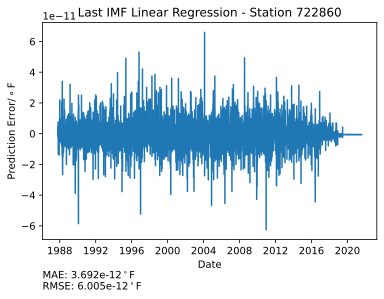

In [6]:
imfs = np.load("runtime/imfs.npy")
lr_last_imf = LinearRegression()
windows = gsod.sliding_window(imfs[-1], 7)[:-1]
Y = imfs[-1][7:]
Xtrain = windows[:20000]
Ytrain = Y[:20000]
lr_last_imf.fit(Xtrain, Ytrain)

error = lr_last_imf.predict(windows[20000:]) - Y[20000:]
plt.plot(interpolated.index[20007:], error)
plt.xlabel("Date")
plt.ylabel("Prediction Error/${}\circ$F")
plt.title(f"Last IMF Linear Regression - Station {STATION}")
plt.annotate(
    f"MAE: {np.average(np.abs(error)):0.4}${{}}^\circ$F\n"
    + f"RMSE: {np.average(error ** 2) ** 0.5:0.4}${{}}^\circ$F",
    (0, -50),
    xycoords="axes points"
)

Error of $10^{-12}$! Impressive!

In [7]:
import pickle
pickle.dump(lr_last_imf, open("runtime/last_imf_linear.pkl", "wb"))